# HW 24-25

# Imports

In [1]:
import warnings

import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
# import PIL
# import scipy
# import sympy as sp
from matplotlib import pyplot as plt

warnings.filterwarnings("ignore")

# HW 24

In [2]:
# In this problem, you will practice using automatic differentiation to construct the Fisher Information
# Matrix of a non-linear system and using said matrix to make informed decisions about sampling.

<img src="model_24.png" alt="formula" width="500">

In [3]:
# (a) Use automatic differentiation to create the Jacobian of this function. Note that your result
# will be a programmatic object, not something that you can write out by hand

def f_x(x, th):
    """
    x: jnp.ndarray (2,)
    th: jnp.ndarray (2,)
    """
    output = jnp.array([
        jnp.exp(-th[0]*x[0])*jnp.tan(th[1]*x[1]),
        jnp.cosh(th[0]*x[0]*x[1])
    ])
    return output

J = jax.jacrev(f_x, argnums=1)


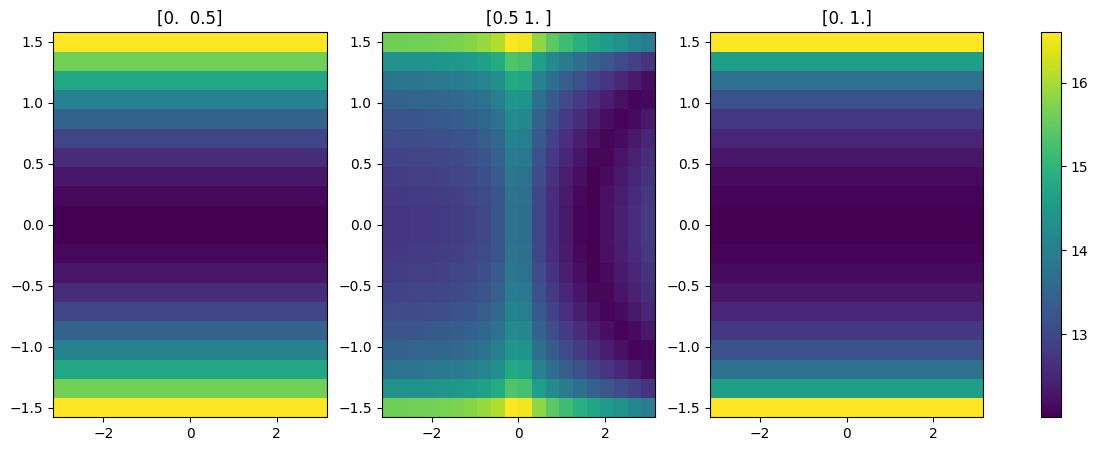

In [4]:
# (b) The experiment that you want to test this model on has three possible sample points: 0, 0.5,
# and 1, but due to cost, you can only choose to sample at two points. Explore the behavior of
# your model by plotting the condition number of the Fisher Information Matrix as a function
# of θ. Use the following procedure:
# • Create three plots, one for each pair of possible sampling points: (0,0.5), (0.5, 1), and (0, 1)
# • Sample θ1 from (-3, 3)
# • Sample θ2 from (-1.5, 1.5) to avoid singularities
# • Use a sparse grid to sample θi to keep computational time low (∼ 20 samples from each θi)
# • Report the base-10 logarithm of the condition number

samples = jnp.array([[0, 0.5],[0.5, 1], [0, 1]])
th_1 = jnp.linspace(-3, 3, 20)
th_2 = jnp.linspace(-1.5, 1.5, 20)

fig, ax = plt.subplots(1, 3, figsize=(15,5))
for i, sample in enumerate(samples):
    ax[i].set_title(sample)

    m = jnp.zeros((3, 20, 20))

    for j, t1 in enumerate(th_1):
        for k, t2 in enumerate(th_2):
            ja = J(sample, jnp.array([t1, t2]))
            FIM = jnp.matmul(ja.T, ja)
            s = jnp.linalg.svd(FIM, compute_uv=False)
            s=s+1e-12 # from zulip
            cn = s[0]/s[-1]
            log_cn = jnp.log10(cn)
            m = m.at[:, j, k].set(jnp.array([t1, t2, log_cn]))
    
    pcm = ax[i].pcolormesh(*m)

fig.colorbar(pcm, ax=ax) # type: ignore

In [5]:
# (c) What does a low condition number tell you about your model? Which of your plots has the
# greatest area with the lowest condition number? With that in mind, which set of sampling
# points is best for this model and why?

# A low condition number suggests that information in our model is evenly distributed across parameters,
# enabling more effective model fitting.
# The (0, 1) plot has the greatest area with the lowest condition number, so I recommend that set of sampling
# points because that some space will be easiest to traverse.

# HW 25

In [6]:
# Imagine that you have been hired by a city to create a model for violent crime in their city.
# The city has given you three potential sampling schemes in param-uncertainty-sampling.txt.
# Given the model:

data = pd.read_csv("./param-uncertainty-sampling.txt", delim_whitespace=True, header=None).values

x = data[:, 0]
y = data[:, 1]
z = data[:, 2]

<img src="model_25.png" alt="formula" width="700">

In [7]:
# (a) Construct the system matrix A for each set of points

def design_mat(vec: np.ndarray) -> np.ndarray:
    """ adapted from HW 19 """
    m = np.array([
        np.sin(2*np.pi*(1/365)*vec),
        np.sin(2*np.pi*(1/30)*vec),
        np.sin(2*np.pi*(1/7)*vec),
        vec,
        np.ones(shape=vec.shape)
    ]).T
    return m

A_x = design_mat(x)
A_y = design_mat(y)
A_z = design_mat(z)

In [8]:
# (b) Calculate the Fisher Information Matrix using the equation AT A for each set of points (Note
# that we have not yet generated a fit, so we are setting σ−2 to 1 for simplicity’s sake).

FIM_x = np.matmul(A_x.T, A_x)
FIM_y = np.matmul(A_y.T, A_y)
FIM_z = np.matmul(A_z.T, A_z)

In [9]:
# (c) Invert the Fisher Information Matrix to yield the covariance matrix. Report the diagonal
# values for each covariance matrix, which are the uncertainties associated with each θ value.

In [10]:
# (c): X: the matrix, including diagonal values are reported here
pd.DataFrame(np.linalg.inv(FIM_x))

,0,1,2,3,4
0,0.039593,-0.000276,-0.000714,4.917626e-05,-0.017949
1,-0.000276,0.033906,-0.000719,-1.916879e-06,0.000333
2,-0.000714,-0.000719,0.033451,-5.016914e-06,0.001948
3,0.000049,-0.000002,-0.000005,4.246699e-07,-0.000155
4,-0.017949,0.000333,0.001948,-1.550002e-04,0.073245


In [11]:
# (c): Y: the matrix, including diagonal values are reported here
pd.DataFrame(np.linalg.inv(FIM_y))

,0,1,2,3,4
0,0.068057,-0.006057,-0.001761,1.061245e-04,-0.046209
1,-0.006057,0.033707,-0.001054,-1.291165e-05,0.002518
2,-0.001761,-0.001054,0.033121,-3.875079e-06,0.000514
3,0.000106,-0.000013,-0.000004,5.592078e-07,-0.000139
4,-0.046209,0.002518,0.000514,-1.393791e-04,0.059725


In [12]:
# (c): Z: the matrix, including diagonal values are reported here
pd.DataFrame(np.linalg.inv(FIM_z))

,0,1,2,3,4
0,0.087249,-0.007362,-0.009974,0.000431,-0.075247
1,-0.007362,0.040865,0.002117,0.000001,-0.002343
2,-0.009974,0.002117,0.034702,-0.000061,0.009003
3,0.000431,0.000001,-0.000061,0.000004,-0.000649
4,-0.075247,-0.002343,0.009003,-0.000649,0.131805


In [13]:
# (d) If the city wants to constrain θ4, which sampling scheme should they choose and why?

# The variance associated with θ4 is least for the first sampling scheme, which corresponds to my x-vector.
# Because of that, to minimize uncertainty with respect to to θ4, I recommend using that dataset.

In [14]:
# (e) In regression problems, σ2 is calculated by scaling the sum of the square errors by the
# degrees of freedom (the number of data points minus the number of parameters in your
# model). Under what circumstances would your answer to part d change after calculating σ2?

# Depending on the fit of the model to the data, the SSE will vary. If a model gives a significantly
# improved fit (measured by SSE), then the uncertainty around the parameters will likely be much lower,
# making that model preferable.

# Acknowledgment
Work in this repository and with associated assignments and projects may be adapted or copied from similar files used in my prior academic and industry work (e.g., using a LaTeX file or Dockerfile as a starting point). Those files and any other work in this repository may have been developed with the help of LLM's like ChatGPT. For example, to provide context, answer questions, refine writing, understand function call syntax, and assist with repetitive tasks. In these cases, deliverables and associated work reflect my best efforts to optimize my learning and demonstrate my capacity, while using available resources and LLM's to facilitate the process.


[ChatGPT Conversation](https://chatgpt.com/share/68e99ef4-14ac-8003-8c66-e97164c94362)